In [ ]:
# Claims Analysis

In [44]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [92]:
import operator
import math
import gb.hypergraph.symbol as sym
import gb.hypergraph.edge as ed
import gb.nlp.parser as par
import gb.tools.json as json_tools
from gb.synonyms.meronomy import Meronomy

import numpy as np
import matplotlib.pyplot as plt

### Constants

In [3]:
MAX_PROB = -12

### Start parser

In [4]:
parser = par.Parser()

### Read data & build full edges list

In [93]:
edge_data = json_tools.read('../all-reddit-worldnews-01012013-01082017.json')

full_edges = []
for it in edge_data:
    full_edges.append(ed.without_namespaces(ed.str2edge(it['edge'])))

### Meronomy and Synonyms

In [94]:
mer = Meronomy(parser, full_edges)
mer.normalize_graph()

mer.generate_synonyms()

### Filter claim hyperedges
(says x ...)

In [95]:
def rel_contains(full_edge, term):
    if sym.is_edge(full_edge) and len(full_edge) > 2 and sym.is_edge(full_edge[2]):
        rel = full_edge[0]
        if sym.is_edge(rel):
            return term in rel
        else:
            return rel == term
    return False


say_edges = []
for full_edge in full_edges:
    if rel_contains(full_edge, 'says'):
        say_edges.append(full_edge)

In [96]:
def edge2str(edge):
    s = ed.edge2str(edge, namespaces=False)
    if sym.is_edge(edge):
        return s

    if s[0] == '+':
        s = s[1:]

    if len(s) == 0:
        return None

    if not s[0].isalnum():
        return None

    word = parser.make_word(s)
    if word.prob < MAX_PROB:
        return s

    return None

def edge2syn(edge):
    atom = edge2str(edge)
    if atom:
        syn_id = mer.syn_id(atom)
        if syn_id:
            return syn_id
    return None

### Sayers, sayers + claims & sorted sayers

In [97]:
sayers = {}
sayers_and_claims = {}
for edge in say_edges:
    sayer = edge2syn(edge[1])
    if sayer not in sayers_and_claims:
        sayers[sayer] = 0
        sayers_and_claims[sayer] = []
    sayers[sayer] += 1
    sayers_and_claims[sayer].append(edge[2])
        
sorted_sayers = sorted(sayers.items(), key=operator.itemgetter(1), reverse=True)

### Concepts by sayer

In [98]:
concepts_by_sayer = {}


def add_concepts(targ, src):
    for key in src:
        if key in targ:
            targ[key] += src[key]
        else:
            targ[key] = src[key]


def concepts_in_claim(claim, concept_map=None, deep=True):
    if not concept_map:
        concept_map = {}
    syn_id = edge2syn(claim)
    if syn_id:
        if syn_id not in concept_map:
            concept_map[syn_id] = 0
        concept_map[syn_id] += 1
        
        if deep:
            if sym.is_edge(claim):
                for item in claim:
                    concepts_in_claim(item, concept_map)
    return concept_map


def get_concepts_by_sayer(sayer, that_include=None):
    concept_map = {}
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        if not that_include:
            add_concepts(concept_map, claim_concepts)
        elif that_include in claim_concepts.keys():
            del claim_concepts[that_include]
            add_concepts(concept_map, claim_concepts)
    return concept_map


for sayer in sayers_and_claims:
    concepts_by_sayer[sayer] = get_concepts_by_sayer(sayer)

### Who talks about who graph

In [101]:
who_who = {}

actors = [sayer for sayer in sayers if sayer and len(sayers_and_claims[sayer]) > 1]
active_actors = set()

def add_edge(orig, targ):
    if orig and targ:
        if orig not in who_who:
            who_who[orig] = {}
        if targ not in who_who[orig]:
            who_who[orig][targ] = 0
        who_who[orig][targ] += 1
        if orig != targ:
            active_actors.add(orig)
            active_actors.add(targ)

for sayer in actors:
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        for concept in claim_concepts:
            if concept in actors:
                add_edge(sayer, concept)
            
file = open('../who_who.gml', 'w')
file.write('graph\n[\n')
for actor in active_actors:
    # print(actor)
    file.write('node\n[\nid %s\nlabel "%s"\n]\n' % (str(actor), mer.synonym_label(actor, short=True)))
for orig in who_who:
    for targ in who_who[orig]:
        w = who_who[orig][targ]
        file.write('edge\n[\nsource %s\ntarget %s\nweight %s\n]\n' % (str(orig), str(targ), str(w)))
file.write(']\n')
file.close()

### Concept-actor graph

In [102]:
concept_actor = {}

def add_edge(orig, targ):
    if orig and targ:
        if orig not in concept_actor:
            concept_actor[orig] = {}
        if targ not in concept_actor[orig]:
            concept_actor[orig][targ] = 0
        concept_actor[orig][targ] += 1

for sayer in actors:
    for claim in sayers_and_claims[sayer]:
        claim_concepts = concepts_in_claim(claim)
        for concept in claim_concepts:
            add_edge(concept, sayer)

concept_metrics = {}
            
for concept in concept_actor:
    weights = [concept_actor[concept][actor] for actor in concept_actor[concept]]
    total = sum(weights)
    h_weights = [float(i) / float(total) for i in weights]
    h_weights = [i * i for i in h_weights]
    h = 1. / sum(h_weights)
    concept_metrics[concept] = {'total': total, 'h': h}

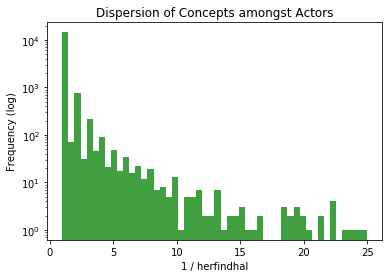

In [103]:
x = [concept_metrics[concept]['h'] for concept in concept_metrics]
x = [i for i in x if i < 25]

# the histogram of the data
n, bins, patches = plt.hist(x, 50, log=True, facecolor='green', alpha=0.75)

plt.xlabel('1 / herfindhal')
plt.ylabel('Frequency (log)')
plt.title('Dispersion of Concepts amongst Actors')

plt.show()

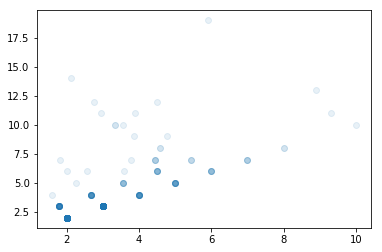

In [67]:
cm = {}
for concept in concept_metrics:
    if concept_metrics[concept]['h'] < 10 and concept_metrics[concept]['h'] > 1:
        cm[concept] = concept_metrics[concept]
x = [cm[concept]['h'] for concept in cm]
y = [cm[concept]['total'] for concept in cm]

plt.scatter(x, y, alpha=0.1)
plt.show()

## Experiments

In [99]:
for t in sorted_sayers[:20]:
    syn_id = t[0]
    if syn_id:
        print('%s %s %s %s' % (syn_id, mer.synonym_label(syn_id), t[1], len(concepts_by_sayer[syn_id])))

900755 {russia} 196 979
900105 {iran} 110 455
233 {korea, (+ north korea)} 106 433
900613 {putin} 92 446
899993 {turkey} 70 355
900731 {ukraine} 67 258
845 {francis, pope, (+ pope francis)} 59 301
906330 {erdogan} 48 199
1354 {arabia, saudi, (+ saudi arabia)} 46 239
899976 {syria} 44 177
901879 {pakistan} 42 171
900578 {france} 41 204
914672 {(+ south korea)} 38 191
801 {cameron, david, (+ david cameron)} 34 154
900097 {japan} 32 180
455 {kremlin, (+the kremlin)} 31 143
39 {(+ angela merkel), angela, merkel} 31 170
900473 {trump} 30 126
899969 {eu} 27 140


In [11]:
concepts = concepts_by_sayer[20]

sorted_concepts = sorted(concepts.items(), key=operator.itemgetter(1), reverse=True)
for t in sorted_concepts[:20]:
    syn_id = t[0]
    if syn_id:
        print('%s %s' % (mer.synonym_label(syn_id), t[1]))

{donald, trump, (+ donald trump)} 28
{(+ bernie sanders), sanders, bernie} 25
{(+of use (+a (+private (+ email server)))), (+a (+private (+ email server))), (+for investigation (+her (+of use (+a (+private (+ email server)))))), (+private (+ email server)), (+federal (+for investigation (+her (+of use (+a (+private (+ email server))))))), (+ email server), (+under (+federal (+for investigation (+her (+of use (+a (+private (+ email server)))))))), (+over (+her (+of use (+a (+private (+ email server)))))), (+her (+of use (+a (+private (+ email server)))))} 6
{(+about (+hard (+' choices))), (+hard (+' choices)), (+' choices), (+but it (+about (+hard (+' choices))))} 4
{(+ his homework’), homework’, (+ bank regulation), (+on (+ his homework’) (+ bank regulation))} 4
{paranoia, (+and paranoia prejudice), prejudice, (+on (+and paranoia prejudice))} 4
{(+$ 200,000), 200,000, (+in (+just (+more (+than (+$ 200,000)))) income), (+about (+$ 200,000)), (+than (+$ 200,000)), (+more (+than (+$ 200,0

In [84]:
# common concepts

actor1 = 8    # sanders
actor2 = 19   # hillary

concepts1 = set(concepts_by_sayer[actor1].keys())
concepts2 = set(concepts_by_sayer[actor2].keys())

common = concepts1.intersection(concepts2)
for concept in common:
    print('*** %s %s %s' % (mer.synonym_label(concept, short=True),
                            concept_actor[concept][actor1],
                            concept_actor[concept][actor2]))
    for claim in sayers_and_claims[actor1]:
        claim_concepts = concepts_in_claim(claim)
        if concept in claim_concepts:
            print('###')
            for concept_ in claim_concepts:
                if concept != concept_:
                    print('> %s %s' % (actor1, mer.synonym_label(concept_, short=True)))
    for claim in sayers_and_claims[actor2]:
        claim_concepts = concepts_in_claim(claim)
        if concept in claim_concepts:
            print('###')
            for concept_ in claim_concepts:
                if concept != concept_:
                    print('> %s %s' % (actor2, mer.synonym_label(concept_, short=True)))

*** the tpp 1 1
###
> 8 clinton frustrating plan allies to_block tpp vote
> 8 hillary clinton
> 8 frustrating plan
> 8 to_block tpp vote
> 8 to_block
> 8 tpp vote
###
> 19 did_n't_endorse she the tpp trade deal until was_actually_negotiated it
> 19 did_n't_endorse
> 19 the tpp trade deal
> 19 tpp trade deal
> 19 until was_actually_negotiated it
*** donald trump 11 20
###
###
> 8 donald infrastructure plan 's trump
> 8 infrastructure plan
> 8 's trump
###
> 8 trump n't_let sanders not but dwelling on bill 's sex life clinton
> 8 n't_let sanders not but dwelling on bill 's sex life clinton
> 8 n't_let
> 8 sanders not but dwelling on bill 's sex life clinton
> 8 bernie sanders
> 8 not but dwelling on bill 's sex life clinton
> 8 but dwelling
> 8 on bill
> 8 's sex life clinton
> 8 sex life
> 8 hillary clinton
###
> 8 's_joining he forces with hillary clinton to_see defeated_badly donald trump
> 8 with hillary clinton
> 8 hillary clinton
> 8 to_see defeated_badly donald trump
> 8 to_see
> 

In [64]:
concepts = get_concepts_by_sayer(2, that_include=19)
for concept in concepts:
    print('%s %s' % (mer.synonym_label(concept), concepts[concept]))

{(+polls (+showing (+winning clinton)))} 1
{(+showing (+winning clinton))} 1
{(+winning clinton)} 1
{(+celebrity (+supporters (+hillary (+'s clinton))))} 1
{(+supporters (+hillary (+'s clinton)))} 1
{(+hillary (+'s clinton))} 1
{(+'s clinton)} 2
{(+'s (+ smoking gun) clinton)} 1
{(+scandal (+endless (+gop (+and (+no investigations (+ smoking gun)))))), (+gop (+and (+no investigations (+ smoking gun)))), (+and (+no investigations (+ smoking gun))), (+no investigations (+ smoking gun)), (+endless (+gop (+and (+no investigations (+ smoking gun))))), (+ smoking gun)} 1
{(+bill behavior (+'s clinton) (+in lewinsky affair))} 1
{(+in lewinsky affair)} 1
{(+of shadow (+ monica lewinsky)), (+on (+up (+in growing (+the (+of shadow (+ monica lewinsky)))))), lewinsky, (+up (+in growing (+the (+of shadow (+ monica lewinsky))))), monica, (+the (+of shadow (+ monica lewinsky))), (+in growing (+the (+of shadow (+ monica lewinsky)))), (+ monica lewinsky)} 1
{affair} 1
{(+ clinton foundation)} 1
{(+'s b

In [90]:
term1 = 'europe'
term2 = 'africa'
word1 = parser.make_word(term1)
word2 = parser.make_word(term2)
word1.similarity(word2)

0.0